<a href="https://colab.research.google.com/github/danielsj95/ASR_with_NeMo/blob/master/NeMo_ASR_Simple_Training_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NeMo ASR Simple Training Script
[Neural Modules (NeMo)](https://developer.nvidia.com/nvidia-nemo) is a toolkit developed by NVIDIA for creating Conversational AI applications, with prebuilt modules for automatic speech recognition among many others. 

This script demonstrates how to build a simple ASR pipeline with the NeMo framework, to train a model that can recognize voiced numbers and letters. Most of this script follows the sample script provided by NeMo here:
https://github.com/NVIDIA/NeMo/blob/master/examples/asr/notebooks/1_ASR_tutorial_using_NeMo.ipynb


The dataset we will be using is the AN4 dataset, which consists of recordings of people spelling out addresses, names, telephone numbers, etc., **one letter or number at a time**, as well as their corresponding transcripts. It is a small dataset which is easily trainable on a colab instance.

## Download and Import
This notebook has been written with using Google Colab in mind. You may also instead opt to use NeMo's docker container with all of the dependencies pre-installed.

```
docker pull nvcr.io/nvidia/nemo:v0.11
docker run --runtime=nvidia -it --rm -v --shm-size=16g -p 8888:8888 -p 6006:6006 --ulimit memlock=-1 --ulimit stack=67108864 nvcr.io/nvidia/nemo:v0.11
```

We will be using the latest stable version of NeMo (0.11) as of writing.

For more information, please visit their [NeMo's github page](https://github.com/NVIDIA/NeMo).

### Install Dependencies

Along with the required packages, we will be retrieving the yaml file that contains the configurations for the model we will be building.

*Note: The installation will take awhile.

In [ ]:
# If you're using Google Colab and not running locally, run this cell.
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install nemo_toolkit[asr]==0.11.0
!pip install unidecode

# only works on torch 1.4.*, torchaudio 0.4, so we have to downgrade
!pip install torch==1.4.0 torchvision==0.5.0 torchaudio==0.4.0 -f https://download.pytorch.org/whl/torch_stable.html

!mkdir configs
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/master/examples/asr/notebooks/configs/jasper_an4.yaml

### Import Packages

In [3]:
import glob
import os
import subprocess
import tarfile
import wget
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import json

# NeMo's "core" package
import nemo
# NeMo's ASR collection
import nemo.collections.asr as nemo_asr

%matplotlib inline

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2020-08-24 03:46:40 audio_preprocessing:61] Unable to import APEX. Mixed precision and distributed training will not work.


### Download Dataset
Again, we are using the AN4 dataset, which we retrieve from CMU's database.

In [4]:
# Set data directory where AN4 dataset will be stored
data_dir = "."

# Download the dataset
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'http://www.speech.cs.cmu.edu/databases/an4/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

******
Dataset downloaded at: ./an4_sphere.tar.gz


Next we untar the tar file, and convert all the .sph audio files into the .wav format. This is because the framework only processes wav formatted files (and most other ASR frameworks for that matter)

In [5]:
if not os.path.exists(data_dir + '/an4/'):
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")

Converting .sph to .wav...
Finished conversion.
******


In [6]:
# download sample wav files
!wget -q https://raw.githubusercontent.com/danielsj95/asr_practice/master/dan_test_367.wav
!ls

an4  an4_sphere.tar.gz	configs  sample_data


## Looking at an Audio Sample

### Plotting the Waveform
Let's plot a sample waveform, which is a line plot of the sequence of values we read from the file. The audio file is a recording of a man saying the letters "G L E N N". It is clear that that each letter has a different shape (plot of lines).

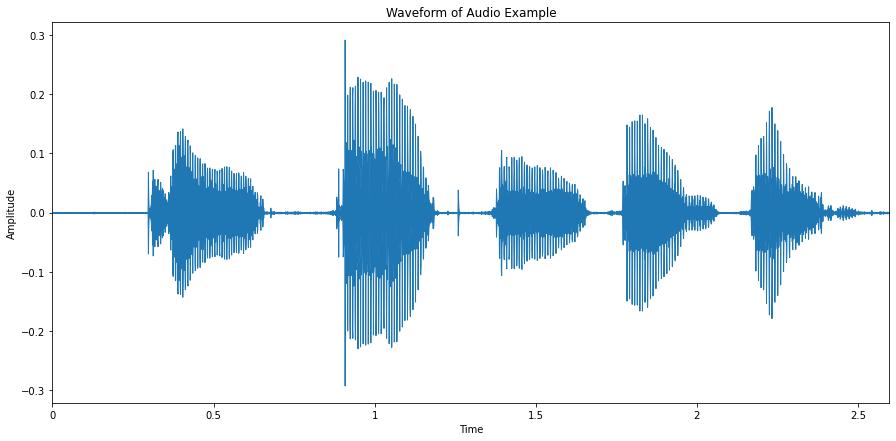

In [7]:
# Load the audio using the librosa library
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

# Plot the audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveplot(audio)

### Converting to Spectrogram
AUdio information is more useful when converted to sound frequencies over time, and to do so, we apply Fourier Transform on the above audio signal. This results in a spectrogram, which is a representation of energy levels of each frequency of the audio signal over time. 

We can observe our sample as a spectrogram using a heatmap as shown below:

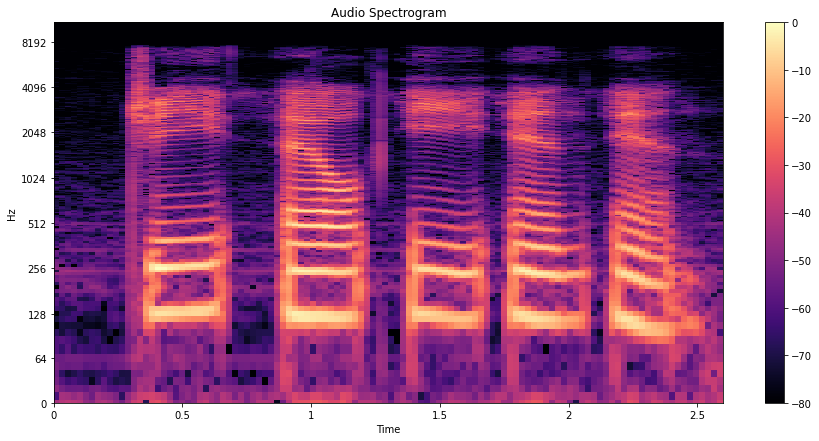

In [8]:
# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

## Preparing the Pipeline

### Creating Data Manifest
For NeMo, a manifest needs to be created for our data, which will contain the metadata of our audio files. NeMo data layers take in a standardized manifest format, with each line corresponding to each audio sample. An example of the manifest is shown below:

```
{"audio_filepath": "path/to/audio_sample.wav", "duration": 6.39, "text": "this is a sample"}
```

The helper function below is used to create the manifest file for our sample set.

In [9]:
# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like this:
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>', '').replace('</s>', '')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]  # e.g. "cen4-fash-b"
                audio_path = os.path.join(
                    data_dir, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                # Write the metadata to the manifest
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n')

In [10]:
# Building Manifests
print("******")
train_transcripts = data_dir + '/an4/etc/an4_train.transcription'
train_manifest = data_dir + '/an4/train_manifest.json'
if not os.path.isfile(train_manifest):
    build_manifest(train_transcripts, train_manifest, 'an4/wav/an4_clstk')
    print("Training manifest created.")

test_transcripts = data_dir + '/an4/etc/an4_test.transcription'
test_manifest = data_dir + '/an4/test_manifest.json'
if not os.path.isfile(test_manifest):
    build_manifest(test_transcripts, test_manifest, 'an4/wav/an4test_clstk')
    print("Test manifest created.")
print("******")

******
Training manifest created.
Test manifest created.
******


### Instantiating Neural Factory

In NeMo, **both the training and inference pipelines are handled by the NeuralModuleFactory class.** It oversees the neural modules (such as the encoders and decoders), checkpointing, callbacks, logs and many other important details. 

In this demo, we will also be using the GPU instance, and as such we explicity stated the device we're using in the *placement* argument.


In [11]:
# Create our NeuralModuleFactory, which will oversee the neural modules.
neural_factory = nemo.core.NeuralModuleFactory(
    log_dir=data_dir+'/an4_tutorial/',
    create_tb_writer=True)

logger = nemo.logging

### Loading the Model in

In this script, we will be following the NeMo tutorial in using the Jasper_4x1 model. The Jasper architecture consists of a repeated block structure at its core, which makes use of 1D convolutions. For more in-depth explanation, check out the paper on the model here: https://arxiv.org/abs/1904.03288

We will be loading in the configurations found in the .yaml file that we downloaded early on. 

In [12]:
# --- Config Information ---#
from ruamel.yaml import YAML

config_path = './configs/jasper_an4.yaml'

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
labels = params['labels'] # Vocab

# --- Instantiate Neural Modules --- #

# Create training and test data layers (which load data) and data preprocessor
data_layer_train = nemo_asr.AudioToTextDataLayer.import_from_config(
    config_path,
    "AudioToTextDataLayer_train",
    overwrite_params={"manifest_filepath": train_manifest}
) # Training datalayer

data_layer_test = nemo_asr.AudioToTextDataLayer.import_from_config(
    config_path,
    "AudioToTextDataLayer_eval",
    overwrite_params={"manifest_filepath": test_manifest}
) # Eval datalayer

data_preprocessor = nemo_asr.AudioToMelSpectrogramPreprocessor.import_from_config(
    config_path, "AudioToMelSpectrogramPreprocessor"
)

# Create the Jasper_4x1 encoder as specified, and a CTC decoder
encoder = nemo_asr.JasperEncoder.import_from_config(
    config_path, "JasperEncoder"
)

decoder = nemo_asr.JasperDecoderForCTC.import_from_config(
    config_path, "JasperDecoderForCTC",
    overwrite_params={"num_classes": len(labels)}
)

ctc_loss = nemo_asr.CTCLossNM(num_classes=len(labels))
greedy_decoder = nemo_asr.GreedyCTCDecoder()

[NeMo I 2020-08-24 03:49:01 neural_modules:343] Loading configuration of a new Neural Module from the `./configs/jasper_an4.yaml` file
[NeMo I 2020-08-24 03:49:02 collections:158] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2020-08-24 03:49:02 collections:159] 0 files were filtered totalling 0.00 hours
[NeMo I 2020-08-24 03:49:02 neural_modules:443] Instantiated a new Neural Module named `audiototextdatalayer0` of type `AudioToTextDataLayer`
[NeMo I 2020-08-24 03:49:02 neural_modules:343] Loading configuration of a new Neural Module from the `./configs/jasper_an4.yaml` file
[NeMo I 2020-08-24 03:49:02 collections:158] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2020-08-24 03:49:02 collections:159] 0 files were filtered totalling 0.00 hours
[NeMo I 2020-08-24 03:49:02 neural_modules:443] Instantiated a new Neural Module named `audiototextdatalayer1` of type `AudioToTextDataLayer`
[NeMo I 2020-08-24 03:49:02 neural_modules:343] Loading configuration of a new

### Setting up our Direct Acyclic Graphs (DAG)

Next, we set up the DAGs for our traning and test sets. We do so by specifying the inputs into each neural module (encoder, decoder, etc.) of our model. 

For our training layer, we will also be augmenting our spectrogram input to increase the size of our dataset. The Spectrogram Augmentation module conducts 3 different augmentations at once - frequency masking, time masking, and zeroing out rectangles of spectrograms.

In [13]:
# --- Assemble Training DAG --- #
audio_signal, audio_signal_len, transcript, transcript_len = data_layer_train()

processed_signal, processed_signal_len = data_preprocessor(
    input_signal=audio_signal,
    length=audio_signal_len)

# Augment our data
spectrogram_aug = nemo_asr.SpectrogramAugmentation(
    rect_masks=5, rect_time=120, rect_freq=50)

processed_signal_aug = spectrogram_aug(input_spec=processed_signal)

encoded, encoded_len = encoder(
    audio_signal=processed_signal_aug,
    length=processed_signal_len)

log_probs = decoder(encoder_output=encoded)
preds = greedy_decoder(log_probs=log_probs)  # Training predictions
loss = ctc_loss(
    log_probs=log_probs,
    targets=transcript,
    input_length=encoded_len,
    target_length=transcript_len)

For our test layer, there is no need to augment the test data as we are simply running through the pipeline to validate our model.

In [14]:
# --- Assemble Validation DAG --- #
(audio_signal_test, audio_len_test,
 transcript_test, transcript_len_test) = data_layer_test()

processed_signal_test, processed_len_test = data_preprocessor(
    input_signal=audio_signal_test,
    length=audio_len_test)

encoded_test, encoded_len_test = encoder(
    audio_signal=processed_signal_test,
    length=processed_len_test)

log_probs_test = decoder(encoder_output=encoded_test)
preds_test = greedy_decoder(log_probs=log_probs_test)  # Test predictions
loss_test = ctc_loss(
    log_probs=log_probs_test,
    targets=transcript_test,
    input_length=encoded_len_test,
    target_length=transcript_len_test)

## Running the Model

### Setting up Callbacks

In this example, we will also be using callbacks to report our loss while our model trains. 

In [15]:
# --- Create Callbacks --- #

# We use these imports to pass to callbacks more complex functions to perform.
from nemo.collections.asr.helpers import monitor_asr_train_progress, \
    process_evaluation_batch, process_evaluation_epoch
from functools import partial

train_callback = nemo.core.SimpleLossLoggerCallback(
    # Notice that we pass in loss, predictions, and the transcript info.
    # Of course we would like to see our training loss, but we need the
    # other arguments to calculate the WER.
    tensors=[loss, preds, transcript, transcript_len],
    # The print_func defines what gets printed.
    print_func=partial(
        monitor_asr_train_progress,
        labels=labels),
    tb_writer=neural_factory.tb_writer
    )

# We can create as many evaluation DAGs and callbacks as we want,
# which is useful in the case of having more than one evaluation dataset.
# In this case, we only have one.
eval_callback = nemo.core.EvaluatorCallback(
    eval_tensors=[loss_test, preds_test, transcript_test, transcript_len_test],
    user_iter_callback=partial(
        process_evaluation_batch, labels=labels),
    user_epochs_done_callback=process_evaluation_epoch,
    eval_step=500,  # How often we evaluate the model on the test set
    tb_writer=neural_factory.tb_writer
    )

checkpoint_saver_callback = nemo.core.CheckpointCallback(
    folder=data_dir+'/an4_checkpoints',
    step_freq=1000  # How often checkpoints are saved
    )

if not os.path.exists(data_dir+'/an4_checkpoints'):
    os.makedirs(data_dir+'/an4_checkpoints')

[NeMo W 2020-08-24 03:49:05 deprecated:66] Function ``__init__`` is deprecated. It is going to be removed in the 0.12 version. The callback section of NeMo has been updated.


### Training Starts
We finally call the train method of our neural factory to start training. We will be using [Word Error Rate (WER)](https://en.wikipedia.org/wiki/Word_error_rate), based on the Levenshtein's distance calculations, to evaluate our results. We would want as less errors as possible, so we're aiming for a low WER. In this sample, we will be training over 100 epochs, and we will expect our WER to be around 20-25%.

In [ ]:
neural_factory.train(
    tensors_to_optimize=[loss],
    callbacks=[train_callback, eval_callback, checkpoint_saver_callback],
    optimizer='novograd',
    optimization_params={
        "num_epochs": 100, "lr": 0.01, "weight_decay": 1e-4
    })

### Inference
Lastly, in order to run inference, we just have to use the infer method of the neural factory, with the built tensors, to get our results.

In [17]:
# --- Inference Only --- #

# We've already built the inference DAG above, so all we need is to call infer().
evaluated_tensors = neural_factory.infer(
    # These are the tensors we want to get from the model.
    tensors=[loss_test, preds_test, transcript_test, transcript_len_test],
    # checkpoint_dir specifies where the model params are loaded from.
    checkpoint_dir=(data_dir+'/an4_checkpoints')
    )

# Process the results to get WER
from nemo.collections.asr.helpers import word_error_rate, \
    post_process_predictions, post_process_transcripts

greedy_hypotheses = post_process_predictions(
    evaluated_tensors[1], labels)

references = post_process_transcripts(
    evaluated_tensors[2], evaluated_tensors[3], labels)

wer = word_error_rate(hypotheses=greedy_hypotheses, references=references)
print("*** Greedy WER: {:.2f} ***".format(wer * 100))

[NeMo I 2020-08-24 04:10:56 actions:1574] Restoring JasperEncoder from ./an4_checkpoints/JasperEncoder-STEP-2000.pt
[NeMo I 2020-08-24 04:10:56 actions:1574] Restoring JasperDecoderForCTC from ./an4_checkpoints/JasperDecoderForCTC-STEP-2000.pt
[NeMo I 2020-08-24 04:10:56 actions:695] Evaluating batch 0 out of 3
[NeMo I 2020-08-24 04:10:56 actions:695] Evaluating batch 1 out of 3
[NeMo I 2020-08-24 04:10:57 actions:695] Evaluating batch 2 out of 3
*** Greedy WER: 24.71 ***


Let's look at some samples and their predictions:

In [18]:
for i in range(5):
  print(f'########## Sample {i+1} ############')
  print('Prediction:', greedy_hypotheses[i])
  print('Actual:    ', references[i])

########## Sample 1 ############
Prediction: rubout  n e three nine
Actual:     rubout g m e f three nine
########## Sample 2 ############
Prediction: erase foc q q f seven
Actual:     erase c q q f seven
########## Sample 3 ############
Prediction: b a oz five three
Actual:     b a o z five three
########## Sample 4 ############
Prediction: 
Actual:     go
########## Sample 5 ############
Prediction: ruboutwt   n e one
Actual:     rubout n i m n one


## Trying Out Our Own Samples
Let's now try on some of our own samples. I have recorded 2 samples, and they can be downloaded from my [repository](https://github.com/danielsj95/ASR_with_NeMo).

In [60]:
!wget -q -O as4_samples.zip https://github.com/danielsj95/ASR_with_NeMo/blob/master/samples/an4_samples.zip?raw=true
!unzip as4_samples.zip

Archive:  as4_samples.zip
   creating: an4_samples/audio_clips/
  inflating: an4_samples/audio_clips/an4_sample_1.wav  
  inflating: an4_samples/audio_clips/an4_sample_2.wav  
   creating: an4_samples/transcripts/
 extracting: an4_samples/transcripts/an4_sample_1.txt  
 extracting: an4_samples/transcripts/an4_sample_2.txt  


The samples are recorded using a headset, and the files are converted to have 16kHz sampling rate.

In [71]:
import IPython.display as ipd

In [73]:
ipd.Audio('an4_samples/audio_clips/an4_sample_1.wav')

In [83]:
ipd.Audio('an4_samples/audio_clips/an4_sample_2.wav')

### Building Manifest

In [92]:
# Function to build sample manifest
def build_sample_manifest(audio_loc, transcript_loc, manifest_path):
    '''
    Build manifest for files in ./test_data
    Arguments:
        filepattern: for glob.glob
    '''
    with open(manifest_path, 'a') as fout:
      for file in os.listdir(audio_loc):

        filename = os.path.splitext(file)[0] # get filename without extension
        duration = librosa.core.get_duration(filename=audio_loc + '/' + file)

        with open(transcript_loc + '/' + filename + '.txt', 'r') as f:
          text = f.readline()

        metadata = {
            "audio_filepath": audio_loc + '/' + file,
            "duration" : duration,
            "text": text
        }
        json.dump(metadata, fout)
        fout.write('\n')
            
    print("test manifest created at {}".format(manifest_path))
    return manifest_path

In [97]:
sample_manifest_path = build_sample_manifest('./an4_samples/audio_clips', './an4_samples/transcripts', 'sample_manifest.json')

test manifest created at sample_manifest.json


### Assembling DAG

In [98]:
data_layer_sample = nemo_asr.AudioToTextDataLayer.import_from_config(
    config_path,
    "AudioToTextDataLayer_eval",
    overwrite_params={"manifest_filepath": sample_manifest_path}
) # Sample with eval datalayer

[NeMo I 2020-08-24 05:22:16 neural_modules:343] Loading configuration of a new Neural Module from the `./configs/jasper_an4.yaml` file
[NeMo I 2020-08-24 05:22:16 collections:158] Dataset loaded with 2 files totalling 0.01 hours
[NeMo I 2020-08-24 05:22:16 collections:159] 0 files were filtered totalling 0.00 hours
[NeMo I 2020-08-24 05:22:16 neural_modules:443] Instantiated a new Neural Module named `audiototextdatalayer6` of type `AudioToTextDataLayer`


In [99]:
# --- Assemble Sample DAG --- #
(audio_signal_sample, audio_len_sample,
 transcript_sample, transcript_len_sample) = data_layer_sample()

processed_signal_sample, processed_len_sample = data_preprocessor(
    input_signal=audio_signal_sample,
    length=audio_len_sample)

encoded_sample, encoded_len_sample = encoder(
    audio_signal=processed_signal_sample,
    length=processed_len_sample)

log_probs_sample = decoder(encoder_output=encoded_sample)
preds_sample = greedy_decoder(log_probs=log_probs_sample)  # 
loss_sample = ctc_loss(
    log_probs=log_probs_sample,
    targets=transcript_sample,
    input_length=encoded_len_sample,
    target_length=transcript_len_sample)

### Inference

In [100]:
evaluated_tensors = neural_factory.infer(
    # These are the tensors we want to get from the model.
    tensors=[loss_sample, preds_sample, transcript_sample, transcript_len_sample],
    # checkpoint_dir specifies where the model params are loaded from.
    checkpoint_dir=(data_dir+'/an4_checkpoints')
    )

greedy_hypotheses = post_process_predictions(
    evaluated_tensors[1], labels)

references = post_process_transcripts(
    evaluated_tensors[2], evaluated_tensors[3], labels)

wer = word_error_rate(hypotheses=greedy_hypotheses, references=references)
print("*** Greedy WER: {:.2f} ***".format(wer * 100))

[NeMo I 2020-08-24 05:22:21 actions:1574] Restoring JasperEncoder from ./an4_checkpoints/JasperEncoder-STEP-2000.pt
[NeMo I 2020-08-24 05:22:21 actions:1574] Restoring JasperDecoderForCTC from ./an4_checkpoints/JasperDecoderForCTC-STEP-2000.pt
[NeMo I 2020-08-24 05:22:21 actions:695] Evaluating batch 0 out of 1
*** Greedy WER: 92.86 ***


Wow, the results are pretty discouraging. It might be due to my mic quality, or it could be some accent differences between mine and the test set's. Or it could simply be due to insufficient training samples.

In [101]:
for i in range(2):
  print(f'########## Sample {i+1} ############')
  print('Prediction:', greedy_hypotheses[i])
  print('Actual:    ', references[i])

########## Sample 1 ############
Prediction:    o  ou seveii 
Actual:     a p p l e four five nine
########## Sample 2 ############
Prediction:  fourr yes k yi y r 
Actual:     four s k y one zero


## Conclusion
The NeMo toolkit makes ASR model training easy and straightforward to implement. The model that we trained was able to generalize well with its own training and test set, but it was insufficient to accurately transcribe audio outside of its own sample.

In the next notebook, I will look into using NeMo's pretrained Jasper model, that trained on a range of datasets, including Singapore's National Speech Corpus. [Click here](https://github.com/danielsj95/ASR_with_NeMo/blob/master/NeMo_ASR_Pretrained_Model_Script.ipynb) to access the next notebook right away.

## References

#### Referenced Notebook
https://github.com/NVIDIA/NeMo/blob/master/examples/asr/notebooks/1_ASR_tutorial_using_NeMo.ipynb

#### Jasper: An End-to-End Convolutional Neural Acoustic Model
https://arxiv.org/abs/1904.03288

## Citations

```
@misc{nemo2019,
    title={NeMo: a toolkit for building AI applications using Neural Modules},
    author={Oleksii Kuchaiev and Jason Li and Huyen Nguyen and Oleksii Hrinchuk and Ryan Leary and Boris Ginsburg and Samuel Kriman and Stanislav Beliaev and Vitaly Lavrukhin and Jack Cook and Patrice Castonguay and Mariya Popova and Jocelyn Huang and Jonathan M. Cohen},
    year={2019},
    eprint={1909.09577},
    archivePrefix={arXiv},
    primaryClass={cs.LG}
}
```